# TP1 : EDP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 125

#### Explicit Euler

In [14]:
import numpy as np

class ExplicitEuler:
    def __init__(self, N, I):
        self.N = N
        self.I = I
        self.K = 100
        self.Smin = 0
        self.Smax = 200
        self.T = 1
        self.sigma = 0.2
        self.r = 0.1
        self.h = (self.Smax - self.Smin)/(self.I + 1)
        self.dt = self.T/self.N
        self.S = np.arange(self.Smin, self.Smin, self.h)
        print(self.S)
        self.time = np.arange(0, self.T, self.dt)
        self.SCHEME = "EE"
        self.A = self.createA()

    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)

    def uleft(self, t):
        return self.K * np.exp(-self.r * t) - self.Smin

    def uright(self, t):
        return 0

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)

    def createA(self):
        A = np.zeros((self.I, self.I))
        for i in range(1, self.I+1):
            A[i-1][i-1] = 2 * self.alpha(i) + self.r
            if i < self.I:
                A[i-1][i] = -self.alpha(i) - self.beta(i)
            if i > 1:
                A[i-1][i-2] = -self.alpha(i) + self.beta(i)
        return A

    def q(self, t):
        y = np.zeros((self.I, 1))
        y[0] = (-self.alpha(1) + self.beta(1)) * self.uleft(t)
        y[self.I-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y

    def createU(self):
        U = np.zeros(self.I)
        for i in range(self.I):
            print(self.S[i])
            U[i] = self.u0(self.S[i])
        return U

    def solve(self):
        print('N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME)
        
        A = self.createA()
        U = self.createU()
        
        print(U)
        
        for n in range (self.N):
            U = U - self.dt * (A@U + self.q(self.time[n]))
        
        return U

ee = ExplicitEuler(10, 9)
U = ee.solve()
print(U)
plot(U)

print(U.shape)
print(ee.S.shape)
plot(ee.S, U)
plt.plot(time_array, U)
plt.title('Plot of Functions')
plt.show()

[]
N = 10 I =  9 SCHEME = EE


IndexError: index 0 is out of bounds for axis 0 with size 0

## Numerical tests

### a)

N = 10 I = 10 SCHEME = EE


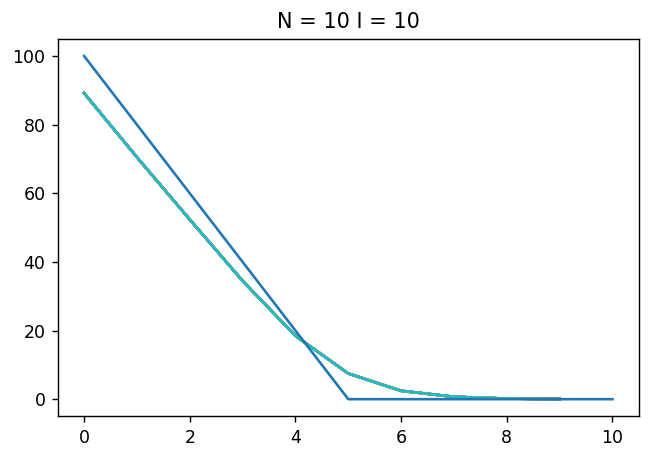

N = 10 I = 20 SCHEME = EE


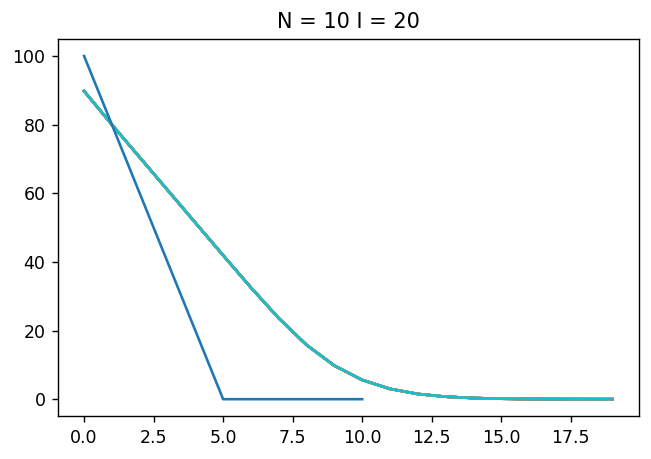

N = 10 I = 50 SCHEME = EE


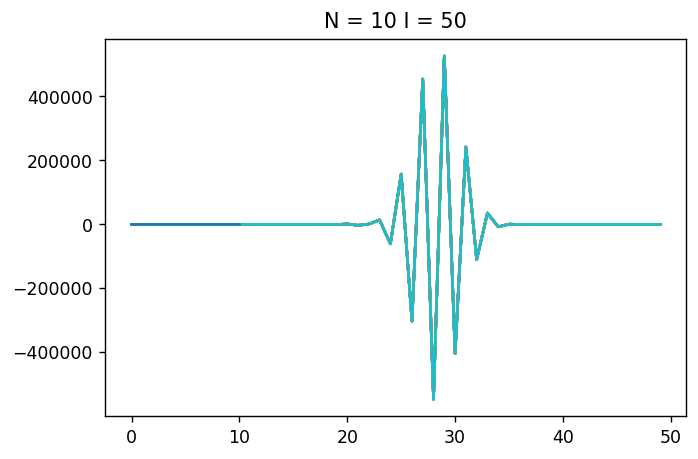

In [171]:
N = 10
Is = [10, 20, 50]

for i in Is:
    I = i
    plot(ExplicitEuler(N, I).solve())
    plot(u0(S))
    plt.title(f"N = {N} I = {I}")
    plt.show()

N = 10 I = 10 SCHEME = EE


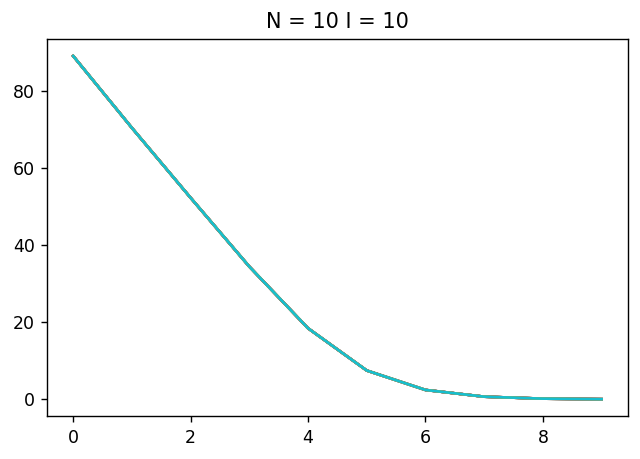

N = 20 I = 20 SCHEME = EE


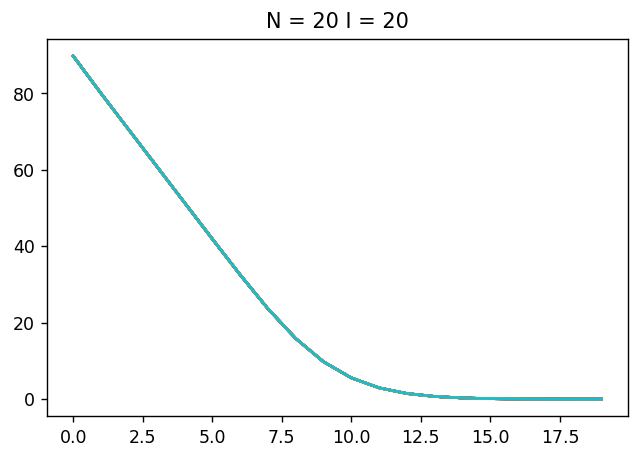

N = 50 I = 50 SCHEME = EE


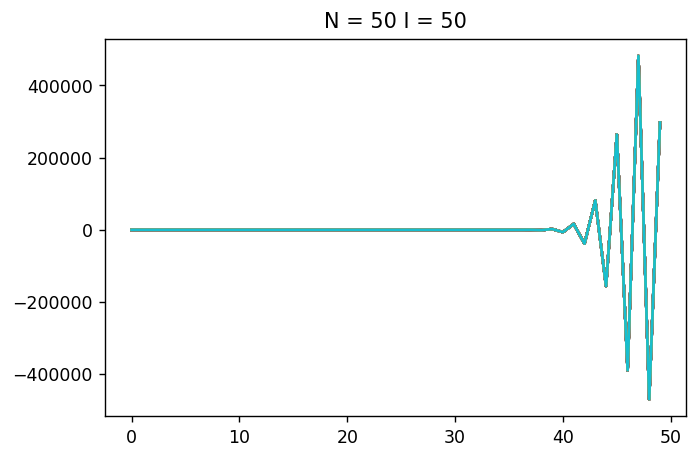

N =100 I =100 SCHEME = EE


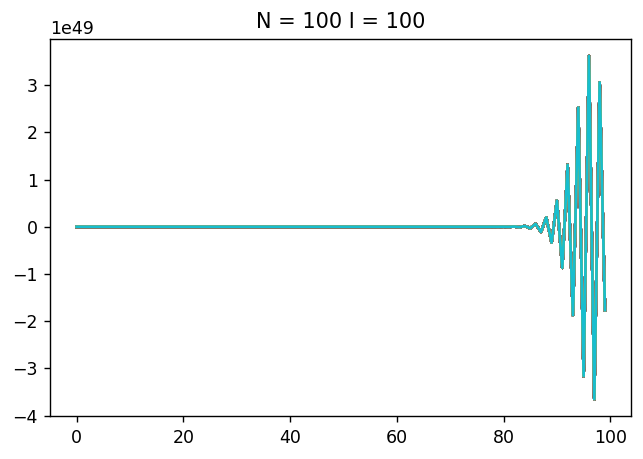

In [172]:
Is = [10, 20, 50, 100]
for i in Is:
    I = i
    N = i
    plot(ExplicitEuler(N, I).solve())
    plt.title(f"N = {N} I = {I}")
    plt.show()

### b)

In [177]:
N = 10
I = 50

ee = ExplicitEuler(N, I)

A = ee.A
B = np.eye(I) - dt*A

print("B : ", B)

B :  [[ 9.986e-01  7.000e-04  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [-2.000e-04  9.974e-01  1.800e-03 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  3.000e-04  9.954e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00 ...  7.740e-02  4.848e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  4.557e-01  3.860e-02  5.047e-01]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  4.750e-01 -1.000e-03]]


In [8]:
print("Valeurs de B négatives : ", B[np.where(B < 0)])
print("Valeurs de B > 1 : ", B[np.where(np.abs(B) > 1)])
print("Norme infinie :", np.linalg.norm(B, np.inf))
print("Norme 2 :", np.linalg.norm(B, 2))

NameError: name 'B' is not defined

In [182]:
N = 10
I = 10

ee = ExplicitEuler(N, I)

A = ee.A
B = np.eye(I) - dt*A

print("B : ", B)

B :  [[ 9.986e-01  7.000e-04  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-2.000e-04  9.974e-01  1.800e-03  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  3.000e-04  9.954e-01  3.300e-03  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.200e-03  9.926e-01  5.200e-03  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  2.500e-03  9.890e-01  7.500e-03
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  4.200e-03  9.846e-01
   1.020e-02  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  6.300e-03
   9.794e-01  1.330e-02  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   8.800e-03  9.734e-01  1.680e-02  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.00

In [183]:
print("Valeurs de B négatives : ", B[np.where(B < 0)])
print("Valeurs de B < 1 : ", B[np.where(np.abs(B) < 1)])

Valeurs de B négatives :  [-0.0002]
Valeurs de B < 1 :  [ 9.986e-01  7.000e-04  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.000e-04  9.974e-01
  1.800e-03  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  3.000e-04  9.954e-01  3.300e-03
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  1.200e-03  9.926e-01  5.200e-03  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  2.500e-03  9.890e-01  7.500e-03  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  4.200e-03  9.846e-01  1.020e-02  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  6.300e-03
  9.794e-01  1.330e-02  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  8.800e-03  9.734e-01
  1.680e-02  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.00

## c)

In [188]:
NIs = [(10, 10), (10, 50)]

for N, I in NIs:
    
    mu = (dt/h**2) * sigma ** 2 * Smax ** 2
    print(f"Mu for I = {I}, N = {N} is {mu}")

Mu is 0.04000000000000001


## d)